In [35]:
import os
import csv
import re
from typing import List
from itertools import product

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from read_data import read_all_datasets
from util import flatten, flatten_twice
from url_tokenizer import url_tokenizer, UrlData, flatten_url_data, \
                          url_raw_splitter, url_html_decoder
from featurizer import UNTRUSTWORTHY_TLDS

### These constants should be left untouched

In [2]:
# Should be left untouched
IS_HTTPS = 'IS_HTTPS'
NUM_MAIN_DOMAIN_WORDS = 'NUM_MAIN_DOMAIN_WORDS'
NUM_SUB_DOMAINS = 'NUM_SUB_DOMAINS'
IS_WWW = 'IS_WWW'
IS_WWW_WEIRD = 'IS_WWW_WEIRD'
NUM_PATH_WORDS = 'NUM_PATH_WORDS'
DOMAIN_END_VERDICT = 'DOMAIN_END_VERDICT'
SUB_DOMAINS_NUM_DIGITS = 'SUB_DOMAINS_NUM_DIGITS'
PATH_NUM_DIGITS = 'PATH_NUM_DIGITS'
ARGS_NUM_DIGITS = 'ARGS_NUM_DIGITS'
TOTAL_NUM_DIGITS = 'TOTAL_NUM_DIGITS'
CONTAINS_AT_SYMBOL = 'CONTAINS_AT_SYMBOL'
WORD_COUNT_IN_URL = 'WORD_COUNT_IN_URL'
DOMAIN_LEN = 'DOMAIN_LEN'
PATH_LEN = 'PATH_LEN'
ARGS_LEN = 'ARGS_LEN'
DOT_COUNT_IN_PATH_AND_ARGS = 'DOT_COUNT_IN_PATH_AND_ARGS'
CAPITAL_COUNT = 'CAPITAL_COUNT'
DOMAIN_IS_IP_ADDRESS = 'DOMAIN_IS_IP_ADDRESS'
CONTAINS_SUSPICIOUS_SYMBOL = 'CONTAINS_SUSPICIOUS_SYMBOL'

NUM_FEATS_TOTAL = 20
SEED = 42
np.random.seed(SEED)

### These values can be changed if you want

In [ ]:
VAL_PROP = 0.2
DMOZ_NUM_URLS = 50_000

### These values should be changed to corresponding feature groups

In [4]:
FEAT0 = [IS_HTTPS, IS_WWW]  #, ...
FEAT1 = [NUM_PATH_WORDS, DOMAIN_END_VERDICT] #, ...
# ...

# 
FEAT_GROUPS = [FEAT0, FEAT1]

### From here on out, I think you can leave mostly everything untouched and then just run it

In [ ]:
FEAT_GROUPS = [sorted(feat_group) for feat_group in FEAT_GROUPS]

In [5]:
dmoz, phishing, ilp = read_all_datasets(use_sample=False)
datasets = {
    'DMOZ': dmoz.sample(DMOZ_NUM_URLS, random_state=SEED),
    'ILP': ilp.sample(frac=1, random_state=SEED),
    'Phishing': phishing.sample(frac=1, random_state=SEED)
}

In [6]:
# A modification of our original function that supports arguments determining
# what features to return or exclude
def hand_pick_features(url: str, feat_group: List[str],
                       only_include: bool) -> np.ndarray:
    try:
        url_data = url_tokenizer(url)
        words = flatten_url_data(url_data)

        url_decoded = url_html_decoder(url)
        protocol, domains_raw, path_raw, args_raw = \
            url_raw_splitter(url_decoded)

        domain_len = len(domains_raw)
        path_len = len(path_raw)
        args_len = len(args_raw)

        dot_count_in_path_and_args = path_raw.count('.') + args_raw.count('.')
        capital_count = len([char for char in url_decoded if char.isupper()])

        domain_is_ip_address = int(bool(re.match(r'(\d+\.){3}\d+',
                                                 domains_raw)))
        contain_suspicious_symbol = int(args_raw.find('\\') >= 0 or
                                        args_raw.find(':') >= 0)

        protocol, domains, path, args = url_data
        sub_domains, main_domain, domain_ending = domains

        contains_at_symbol = int(len(path) > 0 and path[-1] == '@')
        is_https = int(protocol == 'https')
        num_main_domain_words = len(main_domain)
        num_sub_domains = len(sub_domains)
        is_www = int(num_sub_domains > 0 and sub_domains[0] == 'www')
        is_www_weird = int(num_sub_domains > 0 and
                           bool(re.match(r'www.+', sub_domains[0])))
        num_path_words = len(path) - contains_at_symbol
        domain_end_verdict = int(domain_ending in UNTRUSTWORTHY_TLDS)

        sub_domain_chars = flatten(sub_domains)
        sub_domains_num_digits = len([char for char in sub_domain_chars
                                      if char.isdigit()])

        path_chars = flatten(path)
        path_num_digits = len([char for char in path_chars if char.isdigit()])

        args_flat = flatten_twice(args)
        args_chars = flatten(args_flat)
        args_num_digits = len([char for char in args_chars if char.isdigit()])

        total_num_digits = (sub_domains_num_digits
                            + path_num_digits
                            + args_num_digits)

        word_court_in_url = len(words) - contains_at_symbol

        all_features = {
            IS_HTTPS: is_https,
            NUM_MAIN_DOMAIN_WORDS: num_main_domain_words,
            NUM_SUB_DOMAINS: num_sub_domains,
            IS_WWW: is_www,
            IS_WWW_WEIRD: is_www_weird,
            NUM_PATH_WORDS: num_path_words,
            DOMAIN_END_VERDICT: domain_end_verdict,
            SUB_DOMAINS_NUM_DIGITS: sub_domains_num_digits,
            PATH_NUM_DIGITS: path_num_digits,
            ARGS_NUM_DIGITS: args_num_digits,
            TOTAL_NUM_DIGITS: total_num_digits,
            CONTAINS_AT_SYMBOL: contains_at_symbol,
            WORD_COUNT_IN_URL: word_court_in_url,
            DOMAIN_LEN: domain_len,
            PATH_LEN: path_len,
            ARGS_LEN: args_len,
            DOT_COUNT_IN_PATH_AND_ARGS: dot_count_in_path_and_args,
            CAPITAL_COUNT: capital_count,
            DOMAIN_IS_IP_ADDRESS: domain_is_ip_address,
            CONTAINS_SUSPICIOUS_SYMBOL: contain_suspicious_symbol
        }

        if only_include:
            selected_features = [all_features[name] for name in feat_group]
        else:
            selected_features = [v for k, v
                                 in sorted(all_features.items())
                                 if k not in feat_group]
        return np.array(selected_features)
    except:
        return (np.zeros(len(feat_group))
                if use_only
                else np.zeros(NUM_FEATS_TOTAL - len(feat_group)))

In [7]:
def clean_url(url: str):
    try:
        words = flatten_url_data(url_tokenizer(url))
        return ' '.join(words)
    except:
        return ''

In [8]:
def run_test(dataset, use_tfidf, feat_group, only_include):
    feats = np.array([hand_pick_features(url, feat_group, only_include)
                     for url in dataset['url']])
    
    num_feats = feats.shape[1]
    for i in range(num_feats):
        dataset[f'feat_{i}'] = feats[:, i]
    extra_features = [f'feat_{i}' for i in range(num_feats)]
    
    trans = StandardScaler()
    if use_tfidf:
        vectorizer_0 = TfidfVectorizer(
            analyzer='word',
            strip_accents='unicode'
        )
        trans = ColumnTransformer([
            ('tfidf_word', vectorizer_0, 'urlCleaned'),
            ('feat', StandardScaler(), extra_features)
        ])
        
        X = dataset[['urlCleaned', *extra_features]]
    else:
        X = dataset[extra_features]
        
    y = dataset['label']
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=VAL_PROP, random_state=SEED)
        

    trans.fit(X_train)
    X_train_pre = trans.transform(X_train)
    
    model = RandomForestClassifier(random_state=SEED, n_jobs=-1)
    model.fit(X_train_pre, y_train)
    
    X_val_pre = trans.transform(X_val)
    y_val_pred = model.predict(X_val_pre)
    
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_micro = f1_score(y_val, y_val_pred, average='micro')
    f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
    acc = accuracy_score(y_val, y_val_pred)

    return f1_macro, f1_micro, f1_weighted, acc

In [9]:
rows = []

for dataset_name, dataset in datasets.items():
    print(f'Running experiments for {dataset_name}...')
    dataset['urlCleaned'] = dataset['url'].apply(clean_url)
    
    params_iter = product(enumerate(FEAT_GROUPS), [True, False], [True, False])
    for (i, feat_group), use_tfidf, only_include in tqdm(list(params_iter)):
        f1_macro, f1_micro, f1_weighted, acc = \
            run_test(dataset.copy(), use_tfidf, feat_group, only_include)
        rows.append({
            'Dataset': dataset_name, 'Use TfIdf': use_tfidf,
            'Feat Group': i, 'Only Include': only_include,
            'F1 Macro': f1_macro, 'F1 Micro': f1_micro, 'F1 Weighted': f1_weighted,
            'Acc': acc
        })

Running experiments for DMOZ...


  0%|          | 0/8 [00:00<?, ?it/s]

use_tfidf: True, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: True


 12%|█▎        | 1/8 [01:20<09:22, 80.34s/it]

use_tfidf: True, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: False


 25%|██▌       | 2/8 [02:57<08:32, 85.36s/it]

use_tfidf: False, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: True


 38%|███▊      | 3/8 [03:12<05:20, 64.20s/it]

use_tfidf: False, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: False


 50%|█████     | 4/8 [03:27<03:17, 49.38s/it]

use_tfidf: True, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: True


 62%|██████▎   | 5/8 [04:50<02:59, 59.74s/it]

use_tfidf: True, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: False


 75%|███████▌  | 6/8 [06:37<02:27, 73.92s/it]

use_tfidf: False, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: True


 88%|████████▊ | 7/8 [06:53<00:56, 56.35s/it]

use_tfidf: False, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: False


100%|██████████| 8/8 [07:07<00:00, 53.38s/it]


Running experiments for ILP...


  0%|          | 0/8 [00:00<?, ?it/s]

use_tfidf: True, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: True


 12%|█▎        | 1/8 [00:01<00:11,  1.69s/it]

use_tfidf: True, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: False


 25%|██▌       | 2/8 [00:03<00:10,  1.71s/it]

use_tfidf: False, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: True


 38%|███▊      | 3/8 [00:04<00:07,  1.54s/it]

use_tfidf: False, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: False


 50%|█████     | 4/8 [00:05<00:05,  1.44s/it]

use_tfidf: True, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: True


 62%|██████▎   | 5/8 [00:07<00:04,  1.55s/it]

use_tfidf: True, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: False


 75%|███████▌  | 6/8 [00:09<00:03,  1.61s/it]

use_tfidf: False, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: True


 88%|████████▊ | 7/8 [00:10<00:01,  1.47s/it]

use_tfidf: False, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: False


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Running experiments for Phishing...


  0%|          | 0/8 [00:00<?, ?it/s]

use_tfidf: True, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: True


 12%|█▎        | 1/8 [00:23<02:44, 23.56s/it]

use_tfidf: True, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: False


 25%|██▌       | 2/8 [00:44<02:17, 22.90s/it]

use_tfidf: False, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: True


 38%|███▊      | 3/8 [01:03<01:48, 21.66s/it]

use_tfidf: False, feat_group: ['IS_HTTPS', 'IS_WWW'], only_include: False


 50%|█████     | 4/8 [01:23<01:23, 20.96s/it]

use_tfidf: True, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: True


 62%|██████▎   | 5/8 [01:44<01:03, 21.07s/it]

use_tfidf: True, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: False


 75%|███████▌  | 6/8 [02:05<00:42, 21.21s/it]

use_tfidf: False, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: True


 88%|████████▊ | 7/8 [02:25<00:20, 20.59s/it]

use_tfidf: False, feat_group: ['DOMAIN_END_VERDICT', 'NUM_PATH_WORDS'], only_include: False


100%|██████████| 8/8 [02:44<00:00, 20.54s/it]


In [12]:
df = pd.DataFrame(rows)
df

,Dataset,Use TfIdf,Feat Group,Only Include,F1 Macro,F1 Micro,F1 Weighted,Acc
0,DMOZ,True,0,True,0.402137,0.443950,0.428770,0.443950
1,DMOZ,True,0,False,0.400627,0.446400,0.428312,0.446400
2,DMOZ,False,0,True,0.035360,0.177950,0.079925,0.177950
3,DMOZ,False,0,False,0.190412,0.282850,0.243683,0.282850
4,DMOZ,True,1,True,0.409935,0.450550,0.434886,0.450550
5,DMOZ,True,1,False,0.399640,0.448950,0.430388,0.448950
6,DMOZ,False,1,True,0.064630,0.242050,0.143483,0.242050
7,DMOZ,False,1,False,0.197836,0.289000,0.250787,0.289000
8,ILP,True,0,True,0.544896,0.716282,0.714970,0.716282
9,ILP,True,0,False,0.612350,0.773390,0.764284,0.773390


In [27]:
def split_dataset(df):
    dropper = lambda df: df.drop(['Use TfIdf', 'Only Include'], axis=1)
    
    with_tfidf = df[df['Use TfIdf'] == True]
    with_tfidf_include = with_tfidf[with_tfidf['Only Include'] == True]
    with_tfidf_exclude = with_tfidf[with_tfidf['Only Include'] == False]
    
    without_tfidf = df[df['Use TfIdf'] == False]
    without_tfidf_include = without_tfidf[without_tfidf['Only Include'] == True]
    without_tfidf_exclude = without_tfidf[without_tfidf['Only Include'] == False]
    
    return (
        with_tfidf_include.drop(['Use TfIdf', 'Only Include'], axis=1),
        with_tfidf_exclude.drop(['Use TfIdf', 'Only Include'], axis=1),
        without_tfidf_include.drop(['Use TfIdf', 'Only Include'], axis=1),
        without_tfidf_exclude.drop(['Use TfIdf', 'Only Include'], axis=1)
    )

with_tfidf_include, with_tfidf_exclude, without_tfidf_include, without_tfidf_exclude = \
    split_dataset(df)

In [74]:
def show_stats(df, desc, y='F1 Macro'):
    sns.catplot(data=df, x='Feat Group', y='F1 Macro',
            col='Dataset', kind='bar')
    plt.show()
    print(df.to_latex(caption=desc, float_format='%.4f', index=False))
    return df

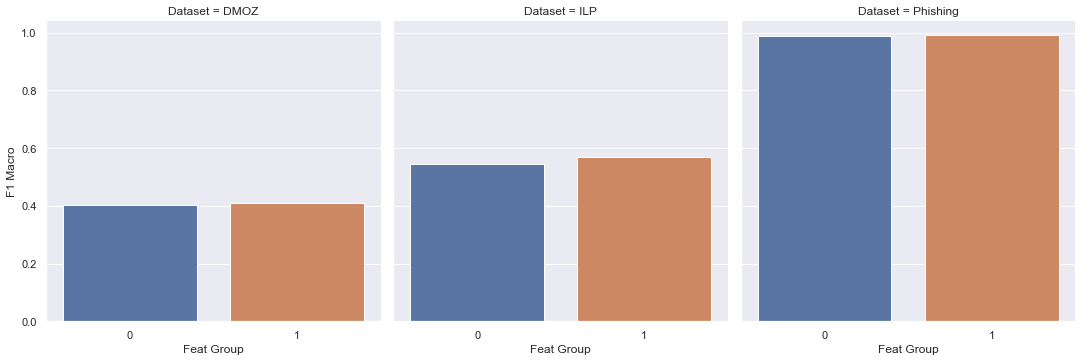

\begin{table}
\centering
\caption{With TfIdf Include}
\begin{tabular}{lrrrrr}
\toprule
  Dataset &  Feat Group &  F1 Macro &  F1 Micro &  F1 Weighted &    Acc \\
\midrule
     DMOZ &           0 &    0.4021 &    0.4440 &       0.4288 & 0.4440 \\
     DMOZ &           1 &    0.4099 &    0.4506 &       0.4349 & 0.4506 \\
      ILP &           0 &    0.5449 &    0.7163 &       0.7150 & 0.7163 \\
      ILP &           1 &    0.5710 &    0.7303 &       0.7210 & 0.7303 \\
 Phishing &           0 &    0.9885 &    0.9922 &       0.9922 & 0.9922 \\
 Phishing &           1 &    0.9921 &    0.9946 &       0.9946 & 0.9946 \\
\bottomrule
\end{tabular}
\end{table}



,Dataset,Feat Group,F1 Macro,F1 Micro,F1 Weighted,Acc
0,DMOZ,0,0.402137,0.443950,0.428770,0.443950
4,DMOZ,1,0.409935,0.450550,0.434886,0.450550
8,ILP,0,0.544896,0.716282,0.714970,0.716282
12,ILP,1,0.571020,0.730255,0.721050,0.730255
16,Phishing,0,0.988513,0.992171,0.992155,0.992171
20,Phishing,1,0.992084,0.994597,0.994590,0.994597


In [75]:
show_stats(with_tfidf_include, 'With TfIdf Include')

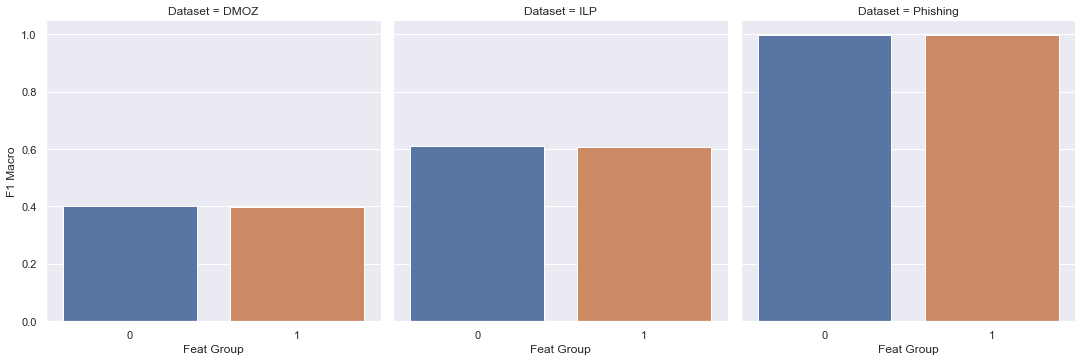

\begin{table}
\centering
\caption{With TfIdf Exclude}
\begin{tabular}{lrrrrr}
\toprule
  Dataset &  Feat Group &  F1 Macro &  F1 Micro &  F1 Weighted &    Acc \\
\midrule
     DMOZ &           0 &    0.4006 &    0.4464 &       0.4283 & 0.4464 \\
     DMOZ &           1 &    0.3996 &    0.4489 &       0.4304 & 0.4490 \\
      ILP &           0 &    0.6123 &    0.7734 &       0.7643 & 0.7734 \\
      ILP &           1 &    0.6056 &    0.7722 &       0.7662 & 0.7722 \\
 Phishing &           0 &    0.9976 &    0.9983 &       0.9983 & 0.9983 \\
 Phishing &           1 &    0.9969 &    0.9979 &       0.9979 & 0.9979 \\
\bottomrule
\end{tabular}
\end{table}



,Dataset,Feat Group,F1 Macro,F1 Micro,F1 Weighted,Acc
1,DMOZ,0,0.400627,0.446400,0.428312,0.446400
5,DMOZ,1,0.399640,0.448950,0.430388,0.448950
9,ILP,0,0.612350,0.773390,0.764284,0.773390
13,ILP,1,0.605604,0.772175,0.766246,0.772175
17,Phishing,0,0.997580,0.998346,0.998345,0.998346
21,Phishing,1,0.996933,0.997905,0.997903,0.997905


In [76]:
show_stats(with_tfidf_exclude, 'With TfIdf Exclude')

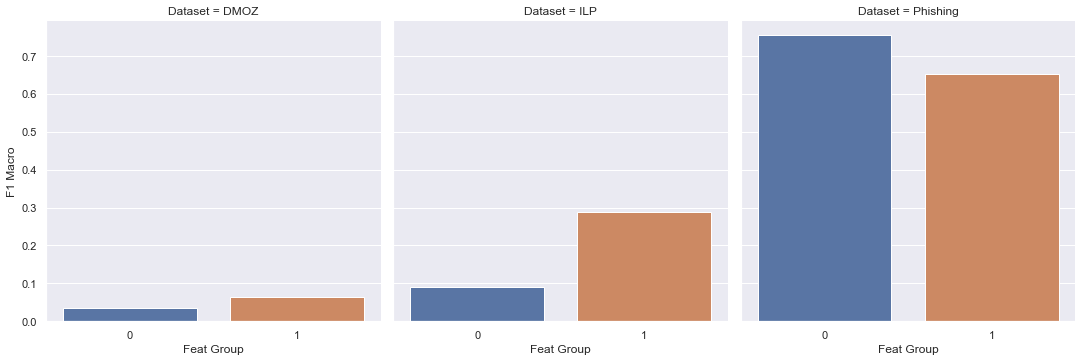

\begin{table}
\centering
\caption{Without TfIdf Include}
\begin{tabular}{lrrrrr}
\toprule
  Dataset &  Feat Group &  F1 Macro &  F1 Micro &  F1 Weighted &    Acc \\
\midrule
     DMOZ &           0 &    0.0354 &    0.1779 &       0.0799 & 0.1779 \\
     DMOZ &           1 &    0.0646 &    0.2420 &       0.1435 & 0.2420 \\
      ILP &           0 &    0.0894 &    0.4550 &       0.2846 & 0.4550 \\
      ILP &           1 &    0.2883 &    0.5273 &       0.4525 & 0.5273 \\
 Phishing &           0 &    0.7553 &    0.8715 &       0.8501 & 0.8715 \\
 Phishing &           1 &    0.6529 &    0.8241 &       0.7898 & 0.8241 \\
\bottomrule
\end{tabular}
\end{table}



,Dataset,Feat Group,F1 Macro,F1 Micro,F1 Weighted,Acc
2,DMOZ,0,0.035360,0.177950,0.079925,0.177950
6,DMOZ,1,0.064630,0.242050,0.143483,0.242050
10,ILP,0,0.089353,0.455043,0.284615,0.455043
14,ILP,1,0.288269,0.527339,0.452485,0.527339
18,Phishing,0,0.755342,0.871540,0.850067,0.871540
22,Phishing,1,0.652865,0.824126,0.789847,0.824126


In [77]:
show_stats(without_tfidf_include, 'Without TfIdf Include')

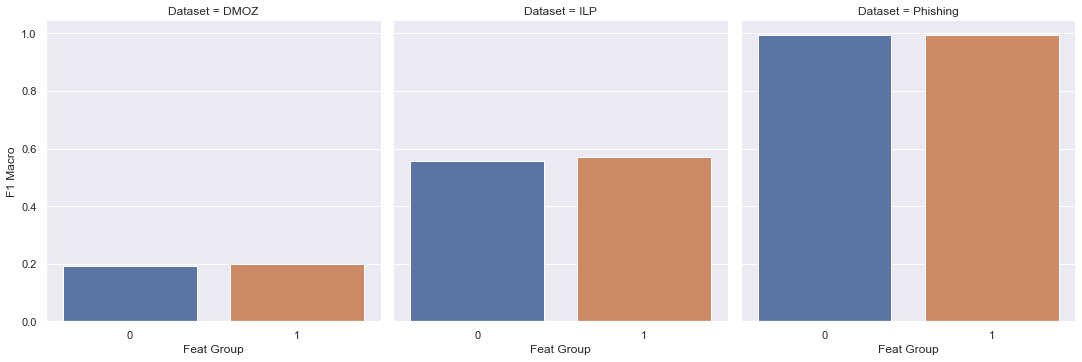

\begin{table}
\centering
\caption{Without TfIdf Exclude}
\begin{tabular}{lrrrrr}
\toprule
  Dataset &  Feat Group &  F1 Macro &  F1 Micro &  F1 Weighted &    Acc \\
\midrule
     DMOZ &           0 &    0.1904 &    0.2828 &       0.2437 & 0.2828 \\
     DMOZ &           1 &    0.1978 &    0.2890 &       0.2508 & 0.2890 \\
      ILP &           0 &    0.5581 &    0.7315 &       0.7197 & 0.7315 \\
      ILP &           1 &    0.5694 &    0.7351 &       0.7257 & 0.7351 \\
 Phishing &           0 &    0.9937 &    0.9957 &       0.9957 & 0.9957 \\
 Phishing &           1 &    0.9942 &    0.9960 &       0.9960 & 0.9960 \\
\bottomrule
\end{tabular}
\end{table}



,Dataset,Feat Group,F1 Macro,F1 Micro,F1 Weighted,Acc
3,DMOZ,0,0.190412,0.282850,0.243683,0.282850
7,DMOZ,1,0.197836,0.289000,0.250787,0.289000
11,ILP,0,0.558109,0.731470,0.719699,0.731470
15,ILP,1,0.569432,0.735115,0.725656,0.735115
19,Phishing,0,0.993692,0.995700,0.995691,0.995700
23,Phishing,1,0.994170,0.996030,0.996020,0.996030


In [78]:
show_stats(without_tfidf_exclude, 'Without TfIdf Exclude')